### MNIST: Deep Convolutional (DC) Generative Adversarial Network (GAN)

### Install/Load Dependencies

In [ ]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
import time
from google.colab import drive
import random

### Mount Google Drive

In [ ]:
# mount drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Metric Modules

In [ ]:
# load inception score metric
inception_path = '/content/drive/MyDrive/neural_networks/modules/inception_score_pytorch'
#!cat '/content/drive/MyDrive/neural_networks/modules/inception_score_pytorch/inception_score.py'
sys.path.append(inception_path)
from inception_score import inception_score
frechet_path = '/content/drive/MyDrive/neural_networks/modules/frechet_inception_distance'
#!cat '/content/drive/MyDrive/neural_networks/modules/frechet_inception_distance/frechet_inception_distance.py'
sys.path.append(frechet_path)
from frechet_inception_distance import frechet_id

### Training Parameters


In [ ]:
num_epochs = 200
batch_size = 64
learning_rate = 2e-4
use_gpu = True
img_size = 64
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
tolerance = 0.0001

### Load MNIST Data

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw




Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


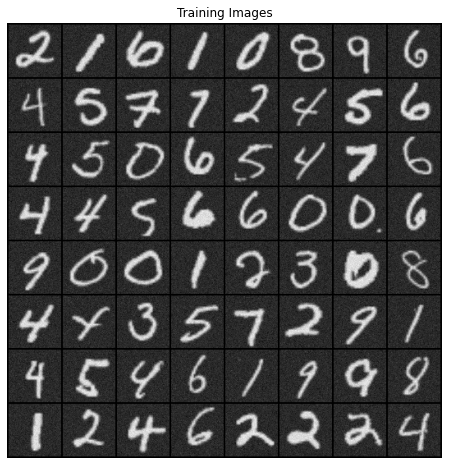

In [ ]:
# set random seed
random.seed(1486438)
torch.manual_seed(1486438)

# custom transform class to add gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, 
                                                                      self.std)

# define transformer for dataloader
# resize and normalize data for slight performance boost
img_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    AddGaussianNoise(0., 0.05)
    ])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, 
                      transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MNIST(root='./data/MNIST', download=True, train=False, 
                     transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Plot some images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, 
                                         normalize=True).cpu(),(1,2,0)))

### Custom weight initialization

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

GAN Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [ ]:
# number of channels (for gray = 1 , for RGB = 3)
nc = 1
# number/size of latent vector z for the generator input
nz = 100
# size/number of feature maps in generator
ngf = 128
# size/number of feature maps in discriminator
ndf = 128
# define fixed noise to sample images from the latent space of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # input to conv. lay. : length of latent vector z 
        self.deconv1 = nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False)
        self.deconv1_bn = nn.BatchNorm2d(ngf*8)
        # state size: (ngf * 8) x 4 x 4
        self.deconv2 = nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False)
        self.deconv2_bn = nn.BatchNorm2d(ngf*4)
        # state size: (ngf * 4) x 8 x 8
        self.deconv3 = nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False)
        self.deconv3_bn = nn.BatchNorm2d(ngf*2)
        # state size: (ngf * 2) x 16 x 16
        self.deconv4 = nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False)
        self.deconv4_bn = nn.BatchNorm2d(ngf)
        # state size: (ngf) x 32 x 32
        self.deconv5 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
        # state size: (nc) x 64 x 64

    def forward(self, input):
        x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # input to conv. lay. : (nc) x 64 x 64
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv1_bn = nn.BatchNorm2d(ndf)
        # state size: (ndf) x 32 x 32
        self.conv2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False)
        self.conv2_bn = nn.BatchNorm2d(ndf*2)
        # state size: (ndf * 2) x 16 x 16
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False)
        self.conv3_bn = nn.BatchNorm2d(ndf*4)
        # state size: (ndf * 4) x 8 x 8
        self.conv4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False)
        self.conv4_bn = nn.BatchNorm2d(ndf*8)
        # state size: (ndf * 8) x 4 x 4
        self.conv5 = nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input))
        x = F.leaky_relu(self.conv1_bn(self.conv1(input)), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x
    
generator = Generator()
discriminator = Discriminator()

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02
#generator.apply(weights_init)
#discriminator.apply(weights_init)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12654336 and discriminator: 11032320


### Define Storage Location

In [ ]:
# mount google drive for saving checkpoints
drive.mount('/content/drive')

# checkpoint generator file name
gen_save_name = 'mnist_gen.cpt'
# define location to store checkpoints for generator
path_gen = F'/content/drive/My Drive/neural_networks/checkpoints/{gen_save_name}'

# checkpoint discriminator file name
disc_save_name = 'mnist_disc.cpt'
# define location to store checkpoints for discriminator
path_disc = F'/content/drive/My Drive/neural_networks/checkpoints/{disc_save_name}'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train GAN
--------


In [ ]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate,
                                 betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate,
                                  betas=(0.5, 0.999))
# set to training mode
generator.train()
discriminator.train()

gen_iter_loss = []
disc_iter_loss = []

gen_loss_avg = []
disc_loss_avg = []
gen_loss_avg.append(0)
disc_loss_avg.append(0)
iters = 0

# store generated images 
img_lst = []
# store generated images for gif
img_lst_gif = []

print('Training ...')
for epoch in range(num_epochs):
    # start countine time 
    start_time = time.time() 
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, i in train_dataloader:
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), nz, 1, 1, device=device)
        fake_image_batch = generator(latent)
        
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        # store loss per iteration
        gen_iter_loss.append(gen_loss.item())
        disc_iter_loss.append(disc_loss.item())

        # average loss per iteration to obtain average loss per epoch
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
        # every 104 batches give print statement
        if num_batches % 104 == 0 :
            print('Epoch [%d / %d], batch [%d / %d]: average loss generator vs. discrim.: %f vs. %f [%s seconds]' %
          (epoch+1, num_epochs, num_batches, len(train_dataloader), gen_loss_avg[-1], disc_loss_avg[-1], round(time.time() - start_time,3)))
        
        # Save generated image if: 
        # 1) at the first iteration
        # 2) final epoch has been reached
        # 3) a full batch of training passed i.e one epoch has passed
        elif (iters == 1) or (epoch == num_epochs) or (iters % len(train_dataloader) == 0):
            # turn off gradient descent computation to minimize computation cost
            with torch.no_grad():
                # generate fake image from generator
                fake = generator(fixed_noise).detach().cpu()
            # store image
            img_lst.append(fake)
            # store image for gif
            img_lst_gif.append(vutils.make_grid(fake, padding=2, normalize=True))
            print('No. of sample images stored: [%d]' % len(img_lst))
        iters += 1
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    # after each epoch print current epoch, generator and discriminator loss and runtime per epoch
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f [%s seconds]'  %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1], round(time.time() - start_time,3)))
    # after each epoch save generator, epochs, loss and images
    print('Generator Checkpoint Saved [%d / %d]' % (epoch + 1, num_epochs))
    torch.save({
            'epoch': epoch,
            'gen_state_dict': generator.state_dict(),
            'optimizer_state_dict': gen_optimizer.state_dict(),
            'gen_loss_avg': gen_loss_avg,
            'gen_iter_loss': gen_iter_loss,
            'img_lst':img_lst,
            'img_lst_gif': img_lst_gif,
            }, path_gen)
    # after each epoch save discriminator, epochs and loss
    # print('Discriminator Checkpoint Saved [%d / %d]' % (epoch + 1, num_epochs))
    torch.save({
            'epoch': epoch,
            'disc_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': disc_optimizer.state_dict(),
            'disc_loss_avg': disc_loss_avg,
            'disc_iter_loss': disc_iter_loss,
            }, path_disc)
    # if difference between current average loss and previous average loss smaler 
    # than tolerance value stop training
    if ( abs(disc_loss_avg[-1] - disc_loss_avg[-2]) <= tolerance) or ( abs(gen_loss_avg[-1] - gen_loss_avg[-2]) <= tolerance):
        print('Generator or Discriminator reached an average loss of approximately 0.')
        print('One of the advaseries/players won the min-max game.')
        print('The game is over.')
        break

### Load Checkpoints

In [ ]:
# load models
disc_save_name = 'mnist_disc.cpt'
gen_save_name = 'mnist_gen.cpt'

path_gen = F'/content/drive/My Drive/neural_networks/checkpoints/{gen_save_name}'
path_disc = F'/content/drive/My Drive/neural_networks/checkpoints/{disc_save_name}'

# check whether checkpoint files exist
if os.path.isfile(path_gen) and os.path.isfile(path_disc) == True:
    checkpoint_gen = torch.load(path_gen)
    checkpoint_disc = torch.load(path_disc)

    # neural net is saved on the gpu we send it to the cpu via .to(device)
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    # given the kernel shut done and all variables are lost
    # optimizers need to be initialised again
    gen_optimizer = torch.optim.Adam(params=generator.parameters(), 
                                     lr=learning_rate, 
                                     betas=(0.5, 0.999))
    disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), 
                                      lr=learning_rate, 
                                      betas=(0.5, 0.999))
    generator.load_state_dict(checkpoint_gen['gen_state_dict'])
    discriminator.load_state_dict(checkpoint_disc['disc_state_dict'])
    gen_optimizer.load_state_dict(checkpoint_gen['optimizer_state_dict'])
    disc_optimizer.load_state_dict(checkpoint_disc['optimizer_state_dict'])
    epoch = checkpoint_gen['epoch']
    img_lst = checkpoint_gen['img_lst']
    img_lst_gif = checkpoint_gen['img_lst_gif']
    gen_loss_avg = checkpoint_gen['gen_loss_avg']
    disc_loss_avg = checkpoint_disc['disc_loss_avg']
    gen_iter_loss = checkpoint_gen['gen_iter_loss']
    disc_iter_loss = checkpoint_disc['disc_iter_loss']
else: 
    print("Checkpoint files not found or do not exist.")
    print("The neural network may have not been trained yet.")
# model_gen.eval()
# - or -
# model_gen.train()

### Figures: First and Last Image

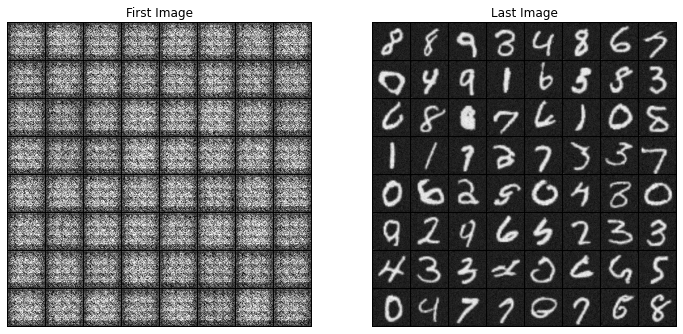

In [ ]:
# plot of generated image
# plot 1st image
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("First Image")
plt.imshow(np.transpose(vutils.make_grid(img_lst[0].to(device), padding=2, 
                                         normalize=True).cpu(),(1,2,0)))
# plot last image
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Last Image")
plt.imshow(np.transpose(vutils.make_grid(img_lst[-1].to(device), padding=2, 
                                         normalize=True).cpu(),(1,2,0)))

### Gif: Image Generation Process

In [ ]:
# gif from starting image to last generated image
# if bytes for gif are too big increase limit 
# plt.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(6,6))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu().numpy(),(1,2,0)), animated=True)] for i in img_lst_gif]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

### Training Curves
--------------------

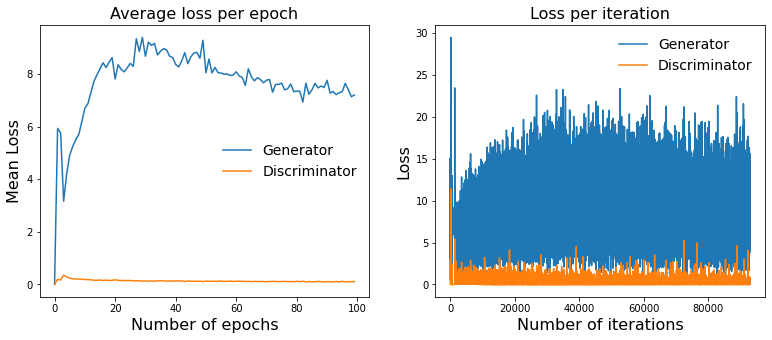

In [ ]:
# Plot average loss per epoch
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(gen_loss_avg, linewidth=1.5)
plt.plot(disc_loss_avg, linewidth=1.5)
plt.title('Average loss per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Mean Loss', fontsize = 16)
plt.legend(['Generator', 'Discriminator'], 
           prop={'size': 14},           
            frameon=False)

# Plot loss per iteration
plt.subplot(1,2,2)
plt.plot(gen_iter_loss, linewidth=1.5)
plt.plot(disc_iter_loss, linewidth=1.5)
plt.title('Loss per iteration', fontsize = 16)
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.legend(['Generator', 'Discriminator'], 
           prop={'size': 14},           
            frameon=False)
plt.show()

### Image Evaluation Metrics

Inception Score

In [ ]:
%%capture
stedv, means = [], []
imgs = []
for j in range(len(img_lst)):
  for i in range(len(img_lst[j])):
    imgs.append((vutils.make_grid(img_lst[j][i].to(device), padding=2, 
                                  normalize=True).cpu()))
  if (j % 20 == 0): 
    print('Average inception score computed for [%d / %d] epochs' % (j, len(img_lst)))
  mean, stdv = inception_score(imgs, cuda=True, batch_size=64, resize=True, splits=10)
  means.append(mean)
  stedv.append(stdv)

Fechet Inception Distance

In [ ]:
%%capture
real_batch = next(iter(train_dataloader))
fids = []
for i in range(len(img_lst)):
  fids.append(frechet_id(img_lst[i], real_batch))

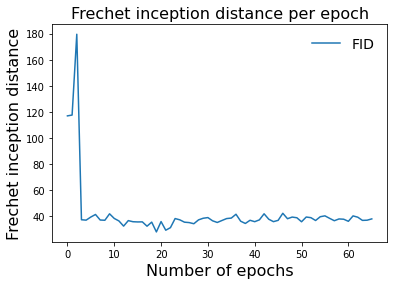

In [ ]:
# Plot average loss per epoch
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(means, linewidth=1.5)
plt.title('Inception score per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Inception score', fontsize = 16)
plt.legend(['IS'], 
           prop={'size': 14},           
            frameon=False)

# Plot loss per iteration
plt.subplot(1,2,2)
plt.plot(fids, linewidth=1.5)
plt.title('Frechet inception distance per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Frechet inception distance', fontsize = 16)
plt.legend(['FID'], 
           prop={'size': 14},           
            frameon=False)
plt.show()

### Plot: Batch of Real vs. Fake Images

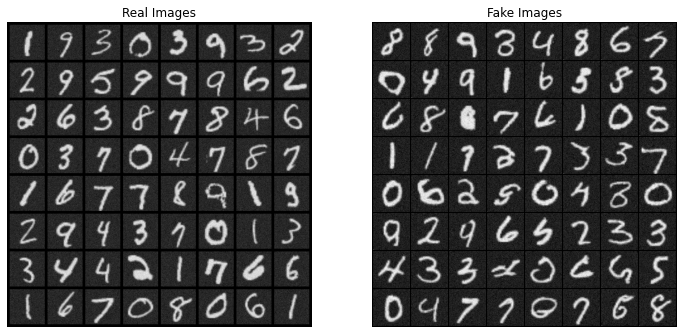

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], 
                                         padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_lst_gif[-1].cpu().numpy(),(1,2,0)))
plt.show()

### Save Single Generatred Image

In [ ]:
# stores a single image
for j in range(len(img_lst)):
  for i in range(len(img_lst[j])):
    torchvision.utils.save_image(img_lst[j][i], '/content/drive/MyDrive/neural_networks/mnist_gen_imgs/%d%d.JPG' % (j,i), normalize = True)
    #imgs.append((vutils.make_grid(img_lst[j][i].to(device), padding=2, normalize=True).cpu()))
  if (j % 20 == 0): 
    print('Stores [%d / %d] image batches' % (j * len(img_lst[0]) , len(img_lst[0])* len(img_lst)))

Stores [0 / 6400] image batches
Stores [1280 / 6400] image batches
Stores [2560 / 6400] image batches
Stores [3840 / 6400] image batches
Stores [5120 / 6400] image batches


### Save Batch of Images 

In [ ]:
# stores an entire batch of images
for i in range(len(img_lst)):
  torchvision.utils.save_image(img_lst[i], '/content/drive/MyDrive/neural_networks/test_images/%d.JPG' % i, normalize = True)
  if (i % 20 == 0):
    print('Finished storing [%d / %d] image batches' % (i, len(img_lst)))

Finished storing [0 / 100] image batches
Finished storing [20 / 100] image batches
Finished storing [40 / 100] image batches
Finished storing [60 / 100] image batches
Finished storing [80 / 100] image batches
